# Improved One Image Overview for screw-thread

Algorithm is based on draft. Purpose of this notebook:
- clean the previous notebook (move all to python files)
- select different part of raw frame for blending

In [1]:
from tqdm.auto import tqdm
from steps.image_row_stitcher import ImageRowStitcher
from steps.video_camera_motion import VideoMotion
import os
import cv2
import imageio.v3 as iio
import numpy as np
import src.pipelines.oio_building_pipeline as oio_builder
from src.config import *
from src.steps.video_frame_lightness import VideoLightness
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import minimize

In [2]:
SRC = '/Users/fathe/OneDrive/Documents/UK/MFF/Thesis/input'

In [3]:
videos = [file for file in os.listdir(SRC) if file.endswith("MP4") and file.startswith("GX")]

In [4]:
videos

['GX010966.MP4',
 'GX010967.MP4',
 'GX010968.MP4',
 'GX010977.MP4',
 'GX010978.MP4']

In [5]:
def process_video(video):
    print(f"Processing video {video}")
    video_file_path = os.path.join(SRC, video)
    # lightness = VideoLightness(video_file_path)
    # lightness.process()
    motions = VideoMotion(video_file_path)
    motions.process()
    
    vidcap = cv2.VideoCapture(video_file_path)
    
    # print(motions.getIntervals())
    
    rows = []
    for i, interval in enumerate(motions.getIntervals()):
        mn, mx = interval
        start = mn + (mx - mn) // 2 - motions.getFramesPer360() // 2
        end = start + motions.getFramesPer360()
        file_path = video_file_path.replace(".MP4", f"-oio-{i}.png")
        if not os.path.isfile(file_path):
            row = oio_builder.construct_row(vidcap, int(start), int(end), direction=motions.getDirection(), rotation=motions.isPortrait(), shift_per_frame=motions.getHorizontalSpeed(), frames_per_360_deg=motions.getFramesPer360())
            rows.append(row)
            iio.imwrite(file_path, row.astype(np.uint8))
            
    stitcher = ImageRowStitcher(SRC, video, motions)
    stitcher.process()

In [6]:
for video in videos:
    process_video(video)

Processing video GX010966.MP4
Intervals: [[   82.  2026.]
 [ 2346.  4290.]
 [ 4504.  6443.]
 [ 6658.  8596.]
 [ 8733. 10676.]
 [10835. 12775.]
 [13079. 15018.]
 [15315. 17038.]] Calculated
Horizontal speed: 12.578990456402597, Vertical shift: 1116.4061254098667, Clockwise: CW, Portrait: True Calculated
[ 2.333777  -7.4335475] (98, 2) (98, 2)
1741
[9.1293545 4.864152 ] (100, 2) (100, 2)
1741
[ 3.0726044 -8.728671 ] (100, 2) (100, 2)
1741
[11.38551   8.216017] (99, 2) (99, 2)
1741
[15.663796 14.795995] (96, 2) (96, 2)
1742
[ 9.1327    -1.8484346] (97, 2) (97, 2)
1741
[7.1285577 1.061068 ] (100, 2) (100, 2)
1741
Unable to read frame: 17155
Frames per 360: 1741.142857142857 calculated from frame_shift: 1740 and frame: 15415
{'roll': 2228, 'scan_shift': 1116, 'first_frame': (1216, 100)}


Computing positions for stitching:   0%|          | 0/7 [00:00<?, ?it/s]

Rolling image for stitching:   0%|          | 0/7 [00:00<?, ?it/s]

Stitching image:   0%|          | 0/7 [00:00<?, ?it/s]

Processing video GX010967.MP4
Intervals: [[  22. 1965.]
 [2227. 4175.]
 [4299. 6241.]
 [6364. 8305.]] Calculated
Horizontal speed: -13.198330747885556, Vertical shift: 1085.4394785549412, Clockwise: CW, Portrait: False Calculated
[ 0.46565232 40.046566  ] (100, 2) (100, 2)
1768
[-3.2515345 30.03642  ] (100, 2) (100, 2)
1767
[-2.9962687 24.477932 ] (99, 2) (99, 2)
1767
[ 4.821612 13.020926] (100, 2) (100, 2)
1768
Frames per 360: 1767.5 calculated from frame_shift: 1767 and frame: 6464


Building row image:   0%|          | 0/1767 [00:00<?, ?it/s]

C:\Users\fathe\OneDrive\Documents\UK\MFF\Thesis\zavity\src\pipelines\oio_building_pipeline.py:63: RuntimeWarning: invalid value encountered in divide
  return np.copy((row_image / weight_matrix))
C:\Users\fathe\AppData\Local\Temp\ipykernel_26216\2123689014.py:22: RuntimeWarning: invalid value encountered in cast
  iio.imwrite(file_path, row.astype(np.uint8))


Building row image:   0%|          | 0/1767 [00:00<?, ?it/s]

Building row image:   0%|          | 0/1767 [00:00<?, ?it/s]

Building row image:   0%|          | 0/1767 [00:00<?, ?it/s]

{'roll': 2360, 'scan_shift': 1085, 'first_frame': (1185, 100)}


Computing positions for stitching:   0%|          | 0/3 [00:00<?, ?it/s]

Rolling image for stitching:   0%|          | 0/3 [00:00<?, ?it/s]

Stitching image:   0%|          | 0/3 [00:00<?, ?it/s]

ValueError: could not broadcast input array from shape (2159,23388) into shape (2159,23237)

 
## Load images

In [7]:
def crop_row(arr):
    return arr[:, np.any((arr != 0), axis=0)]

In [8]:
rows_images = []
for filename in sorted(os.listdir(SRC)):
    if videos[0].replace(".MP4","") + "-oio-" in filename and "png" in filename:
        print(filename)
        rows_images.append(crop_row(iio.imread(os.path.join(SRC, filename))))

GX010980-oio-0.png
GX010980-oio-1.png
GX010980-oio-2.png
GX010980-oio-3.png


In [9]:
len(rows_images)

4

In [10]:
for r in rows_images:
    print(r.shape)

(2160, 20078)
(2160, 20078)
(2160, 20078)
(2160, 20078)


In [11]:
scan_shift = 1538
roll = 2044

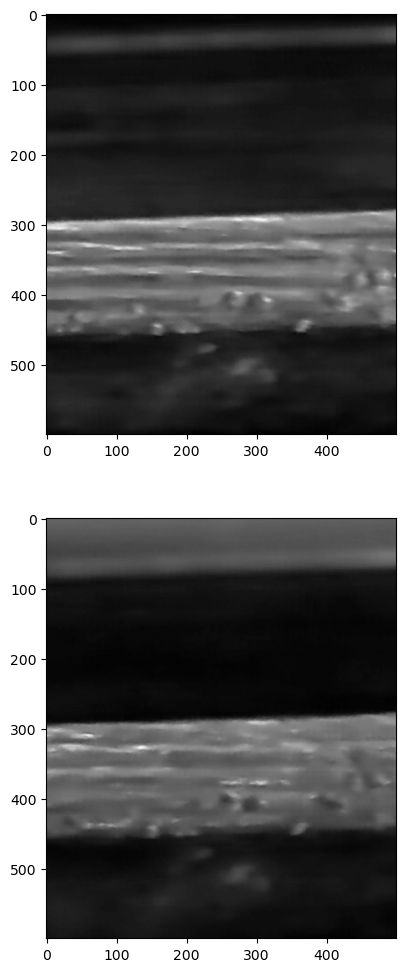

In [12]:
plt.figure(figsize=(20,12))
ax = plt.subplot(211)
ax.imshow(rows_images[2][1560:2160, 5500:6000], cmap="gray")
ax = plt.subplot(212)
ax.imshow(rows_images[3][1560-scan_shift:2160-scan_shift, 5500+roll:6000+roll], cmap="gray")
# ax = plt.subplot(211)
# ax.imshow(rows_images[1][1560:2160, :], cmap="gray")
# ax = plt.subplot(212)
# ax.imshow(rows_images[2][1560-shift:2160-shift, :], cmap="gray")
# ax = plt.subplot(211)
# ax.imshow(rows_images[0][:, 7500:10000], cmap="gray")
# ax = plt.subplot(212)
# ax.imshow(rows_images[1][:, 7500+roll:10000+roll], cmap="gray")
# ax = plt.subplot(513)
# ax.imshow(rows_images[2][:, 5000:7500], cmap="gray")
# ax = plt.subplot(514)
# ax.imshow(rows_images[3][:, 5000:7500], cmap="gray")
# ax = plt.subplot(515)
# ax.imshow(rows_images[4][:, 5000:7500], cmap="gray")

In [13]:
# registration by mutual information
def mutual_information(imgA, imgB, bins=15):
    # taken from https://matthew-brett.github.io/teaching/mutual_information.html    
    hist_2d, x_edges, y_edges = np.histogram2d(
         imgA.ravel(),
         imgB.ravel(),
         bins=bins
    )
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def extract_images_and_compute_mi(shift, imgA, imgB, seed_position):    
    x = np.arange(seed_position[1, 0] + shift[0], seed_position[1, 0] + shift[0] + 599.5)
    y = np.arange(seed_position[1, 1] + shift[1], seed_position[1, 1] + shift[1] + 11999.5)    
    xg, yg = np.meshgrid(x, y)
    # print(xg[0, 0], xg[-1,-1], yg[0,0], yg[-1,-1], imgA.shape, imgB.shape)
    interp = RegularGridInterpolator((np.arange(imgB.shape[0]), np.arange(imgB.shape[1])), imgB)
    return -mutual_information(
        imgA[seed_position[0, 0]: seed_position[0, 0] + 600, 
             seed_position[0, 1]: seed_position[0, 1] + 12000].T,         
        interp((xg, yg))
    )

def to_minimize(x):
    return extract_images_and_compute_mi(shift=x, imgA=imgA, imgB=imgB, seed_position=seed_position)

def show_images(imgA, imgB, seed_position, shift):
    plt.figure(figsize=(8,40))
    ax = plt.subplot(131)
    ax.imshow(imgA[seed_position[0, 0]: seed_position[0, 0] + 600, 
                   seed_position[0, 1]: seed_position[0, 1] + 12000].T, cmap="gray")
    ax.set_title("Fixed")

    x = np.arange(seed_position[1, 0] + shift[0], seed_position[1, 0] + shift[0] + 599.5)
    y = np.arange(seed_position[1, 1] + shift[1], seed_position[1, 1] + shift[1] + 11999.5)    
    xg, yg = np.meshgrid(x, y)
    interp = RegularGridInterpolator((np.arange(imgB.shape[0]), np.arange(imgB.shape[1])), imgB)
    
    ax = plt.subplot(132)
    ax.imshow(interp((xg, yg)), cmap="gray")
    ax.set_title("Moved")

    ax = plt.subplot(133)
    ax.imshow(imgA[seed_position[0, 0]: seed_position[0, 0] + 600, 
                   seed_position[0, 1]: seed_position[0, 1] + 12000].T + interp((xg, yg)), cmap="gray")
    ax.set_title("Blend")
    plt.show()
               

In [14]:
physics = {
    "roll":  np.round(rows_images[0].shape[1] * 0.1).astype(int) + 36,
    "scan_shift": 2160 // 2 + 458,
    "screw_thread_distance": 400,
    "first_frame": [1560, 6000]
}

In [15]:
physics

{'roll': 2044,
 'scan_shift': 1538,
 'screw_thread_distance': 400,
 'first_frame': [1560, 6000]}

In [16]:
scan_shifts = []
rolls = []

In [17]:
first_frame = physics["first_frame"]
scan_shift = physics["scan_shift"]
roll = physics["roll"]

scan_shifts.append(scan_shift)
rolls.append(roll)

seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)
imgA = rows_images[0]
imgB = rows_images[1]
s1 = minimize(to_minimize, x0=np.array([0, 0]), method='COBYLA', bounds=[(-100, +100),(-100, 100)])

In [18]:
s1

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.45151623813221536
       x: [-6.531e+00  4.837e-01]
    nfev: 37
   maxcv: 0.0

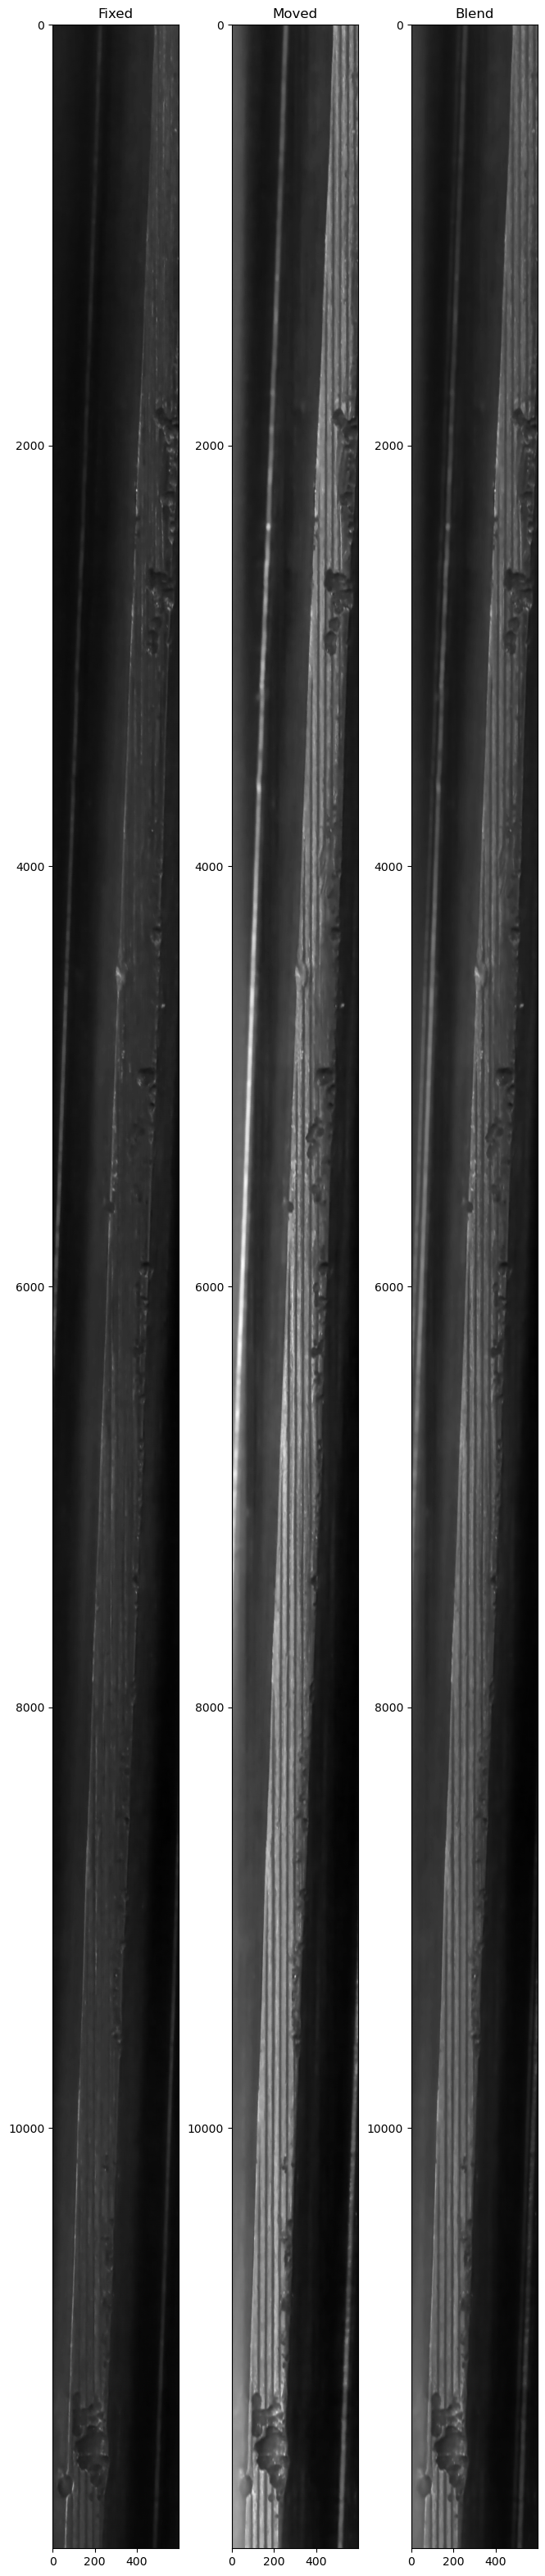

In [19]:
show_images(imgA, imgB, seed_position, s1.x)

In [20]:
screw_thread_distance = physics["screw_thread_distance"]
first_frame = physics["first_frame"]
scan_shift = physics["scan_shift"]

scan_shifts.append(scan_shift)
rolls.append(roll)
seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)
imgA = rows_images[1]
imgB = rows_images[2]
s2 = minimize(to_minimize, x0=[0,0], method='COBYLA', bounds=[(-10, 10),(-10, 10)])

In [21]:
s2

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7897251413080154
       x: [-4.383e+00 -1.755e+00]
    nfev: 41
   maxcv: 0.0

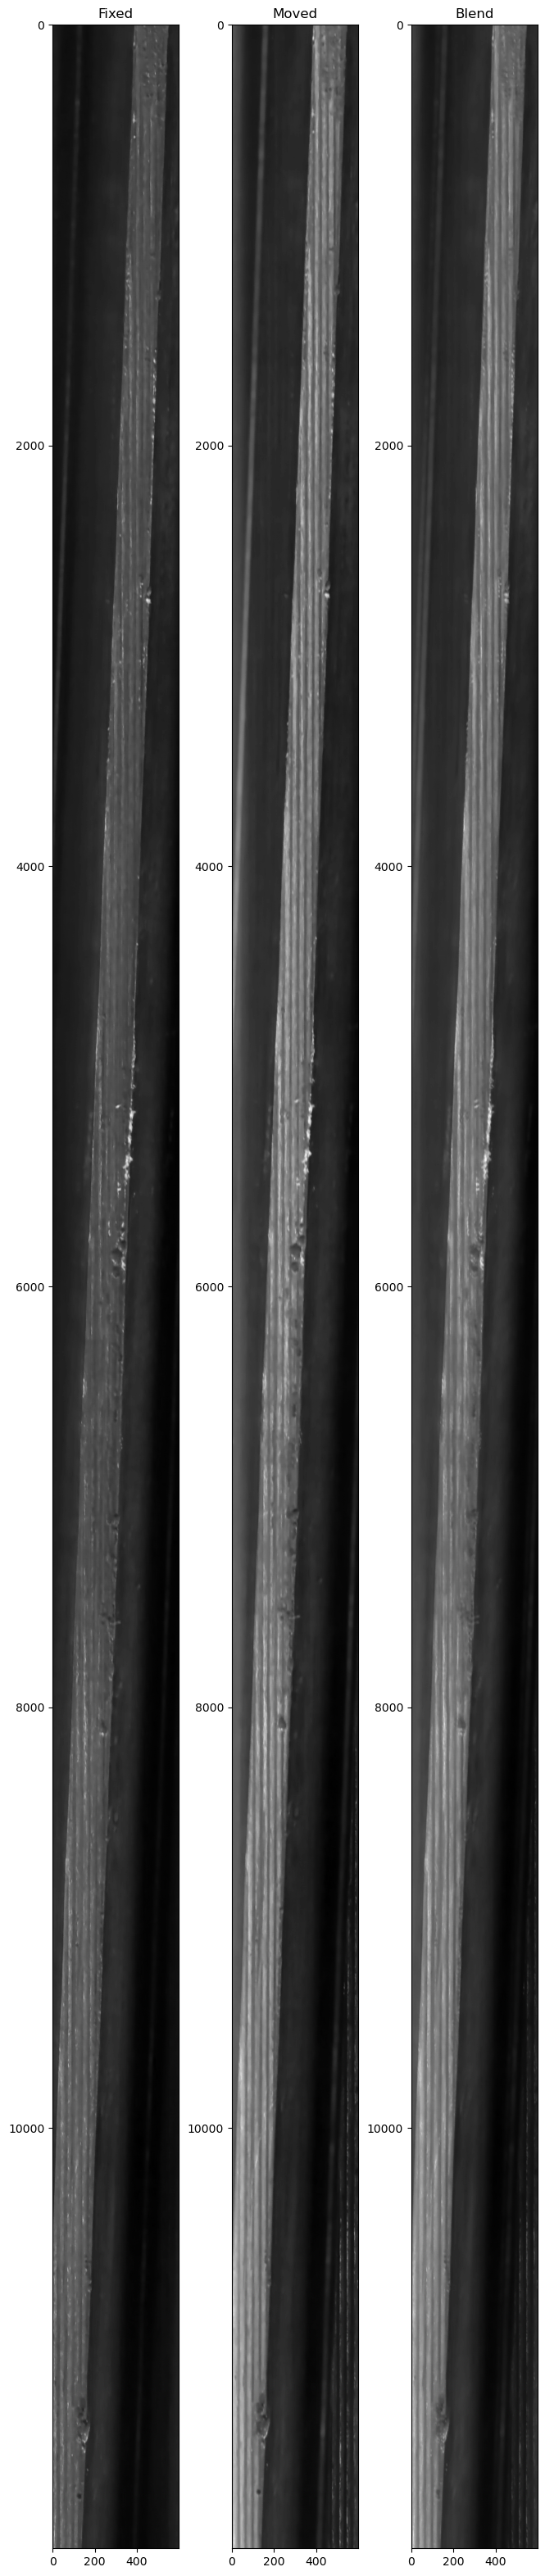

In [22]:
show_images(imgA, imgB, seed_position, s2.x)

In [23]:
seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)

scan_shifts.append(scan_shift)
rolls.append(roll)

imgA = rows_images[2]
imgB = rows_images[3]
s3 = minimize(to_minimize, x0=[0, 0], method='COBYLA', bounds=[(-10, 10),(-10, 10)])

In [24]:
s3

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7676014635010399
       x: [-4.342e-01 -5.011e-01]
    nfev: 34
   maxcv: 0.0

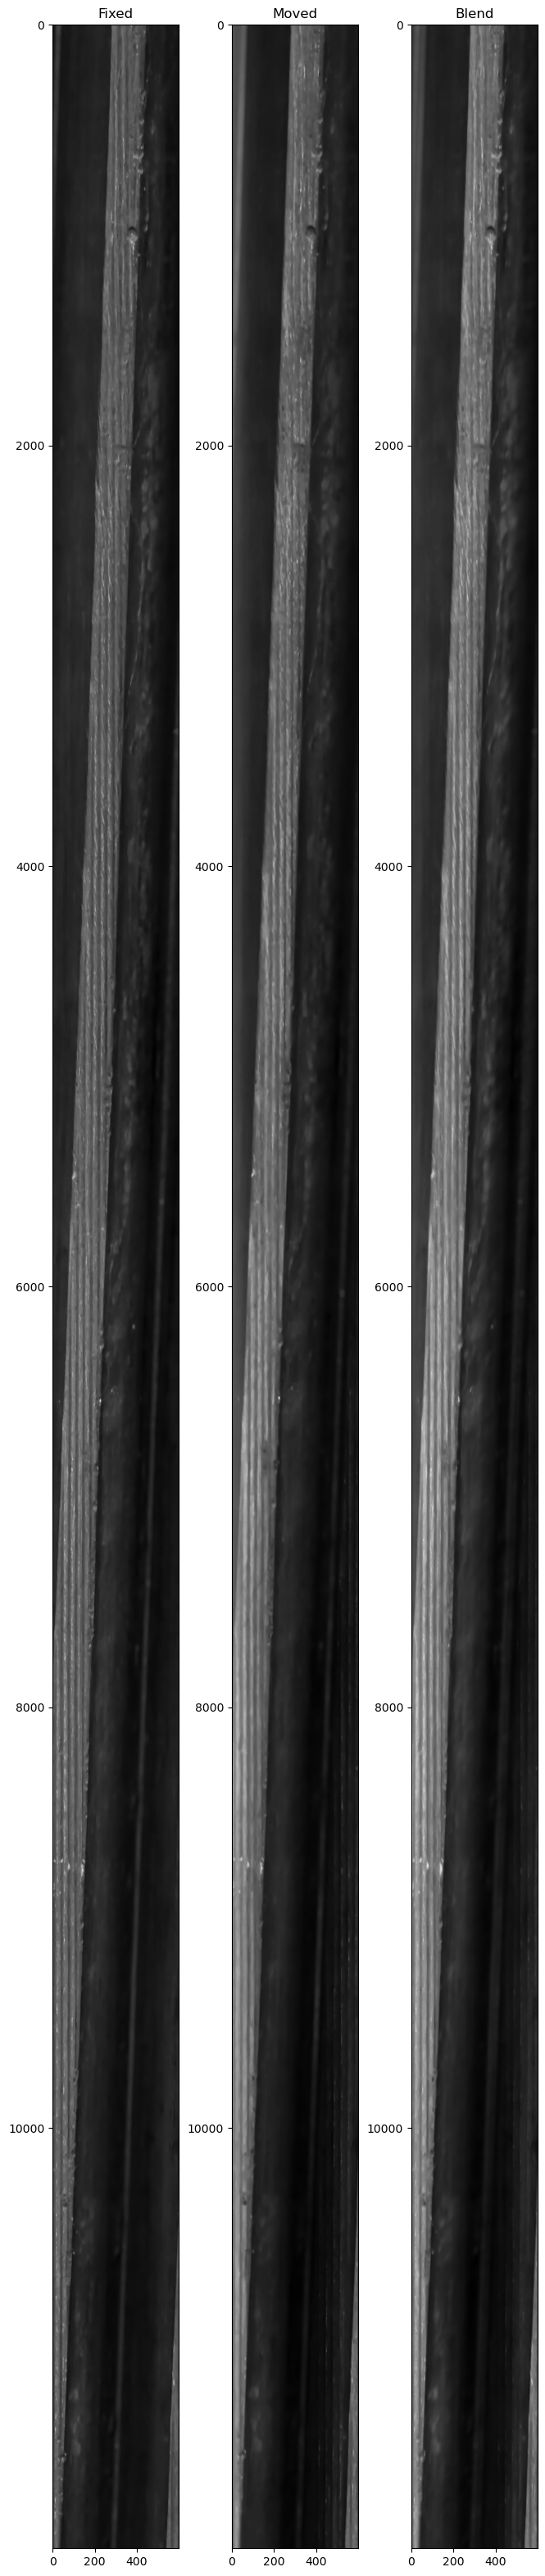

In [25]:
show_images(imgA, imgB, seed_position, s3.x)

In [26]:
scan_shift = 708
roll = 2040
scan_shifts.append(scan_shift)
rolls.append(roll)
seed_position = np.array([first_frame, [first_frame[0] - scan_shift, first_frame[1] + roll]]).astype(int)
imgA = rows_images[3]
imgB = rows_images[4]
s4 = minimize(to_minimize, x0=[0, 0], method='COBYLA', bounds=[(-10, 10),(-10, 10)])

IndexError: list index out of range

In [ ]:
s4

In [ ]:
show_images(imgA, imgB, seed_position, s4.x)

In [ ]:
[[first_frame[0] - 4 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 4 * roll],
 [first_frame[0] - 5 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 5 * roll]]

In [ ]:
seed_position = np.array([[first_frame[0] - 4 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 4 * roll],
                          [first_frame[0] - 5 * scan_shift + 11 * screw_thread_distance, first_frame[1] - 5 * roll]]).astype(int)
imgA = rows_images[4]
imgB = rows_images[5]
s5 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [ ]:
s5

In [ ]:
show_images(imgA, imgB, seed_position, s5.x)

In [ ]:
[[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
 [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]

In [ ]:
seed_position = np.array([[first_frame[0] - 5 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 5 * roll],
                          [first_frame[0] - 6 * scan_shift + 13 * screw_thread_distance, first_frame[1] - 6 * roll]]).astype(int)
imgA = rows_images[5]
imgB = rows_images[6]
s6 = minimize(to_minimize, x0=[0, 0], method='Powell', bounds=[(-10, 10),(-10, 40)])

In [ ]:
s6

In [ ]:
show_images(imgA, imgB, seed_position, s6.x)

In [ ]:
shift_fixes = np.array([s1.x, s2.x, s3.x])

## Merge

- sesbírat posun per row
- aggregovats `sn.x`
- provést roll každé otočky + interpolaci
- vyrobit váhovou matici pro překryv
- vynásobit / flatnout

In [ ]:
shift_seed = []
shift_seed.append(np.array([first_frame, [first_frame[0] - scan_shifts[0], first_frame[1] + rolls[0]]]).astype(int))
shift_seed.append(np.array([first_frame, [first_frame[0] - scan_shifts[1], first_frame[1] + rolls[1]]]).astype(int))
shift_seed.append(np.array([first_frame, [first_frame[0] - scan_shifts[2], first_frame[1] + rolls[2]]]).astype(int))

In [ ]:
per_row_shift = np.array([seed[0, :] - seed[1, :] - fix for seed, fix in zip(shift_seed, shift_fixes)])

In [ ]:
shift_seed

In [ ]:
per_row_shift

In [ ]:
def real_roll(array, shift, axis=0):    
    double_image = np.concatenate([array, array], axis=1)
    interp = RegularGridInterpolator(
        (np.arange(double_image.shape[0]), np.arange(double_image.shape[1])), 
        double_image
    )
    if shift > 0:
        y = np.arange(shift, shift + array.shape[1] - 0.5, 1)
    else:
        y = np.arange(shift + array.shape[1], 2 * array.shape[1] + shift - 0.5, 1)    
    x = np.arange(array.shape[0])    
    xg, yg = np.meshgrid(x, y)    
    return interp((xg, yg)).T

In [ ]:
rows_images[1][:,:12]

In [ ]:
# Test of the real roll function
plt.figure(figsize=(20,6))
ax = plt.subplot(211)
ax.imshow(real_roll(rows_images[1], per_row_shift[0,1]), cmap="gray")
ax.set_title("Rolled")
ax = plt.subplot(212)
ax.imshow(rows_images[1], cmap="gray")
ax.set_title("Original row 1")
plt.show()

In [ ]:
rows_images[0].shape

In [ ]:
rolled = []
# Roll all rows as required and plot them
plt.figure(figsize=(20,20))
ax = plt.subplot(7, 1, 1)
ax.imshow(rows_images[0], cmap="gray")
rolled.append(rows_images[0])
for en, row_shift in enumerate(np.cumsum(-per_row_shift[:,1])):
    ax = plt.subplot(7, 1, en+2)
    rolled.append(real_roll(rows_images[en + 1], row_shift % rows_images[en + 1].shape[1]))
    ax.imshow(rolled[-1], cmap="gray")
    ax.set_title(f"Row {en + 1}, shift: {row_shift % rows_images[en + 1].shape[1]}")
plt.show()

In [ ]:
# merge rows

In [ ]:
to_grid = [rolled[0]]
real_shift = [0]
for image, shift in tqdm(zip(rolled[1:], np.cumsum(per_row_shift[:,0])), total=per_row_shift.shape[0]):
    interp = RegularGridInterpolator(
        (np.arange(image.shape[0]), np.arange(image.shape[1])), 
        image
    )
    x = np.arange(image.shape[0] - 1)
    y = np.arange(image.shape[1])
    xg, yg = np.meshgrid(x,y)
    to_grid.append(interp((xg, yg)).T)
    real_shift.append(int(shift // 1))


In [ ]:
out_height = rolled[0].shape[0] + np.max(real_shift)

In [ ]:
full_image = np.zeros((out_height, rolled[0].shape[1], len(rolled)))
for en, (image, r_shift) in enumerate(zip(to_grid, real_shift)):
    full_image[r_shift: r_shift + image.shape[0], :, en] = image

In [ ]:
blend_matrix = np.zeros((out_height, to_grid[0].shape[1], len(to_grid)))

blend_matrix[:real_shift[1], :, 0] += 1
lin_blend = np.dot(np.arange(0, 1, 1/(to_grid[0].shape[0] - real_shift[1])).reshape(-1, 1), 
                   np.ones((to_grid[0].shape[1],1)).T)
blend_matrix[real_shift[1]: to_grid[0].shape[0], :, 0] += np.flipud(lin_blend)
blend_matrix[real_shift[1]: to_grid[0].shape[0], :, 1] += lin_blend

for en, (image, r_shift) in enumerate(list(zip(to_grid, real_shift))[:-2]):
    blend_matrix[real_shift[en] + to_grid[en].shape[0]: real_shift[en + 2], :, en + 1] += 1
    lin_blend = np.dot(np.arange(0, 1, 1/(to_grid[en + 1].shape[0] + real_shift[en + 1] - real_shift[en + 2])).reshape(-1, 1), 
                       np.ones((to_grid[en + 1].shape[1],1)).T)
    blend_matrix[real_shift[en + 2]: to_grid[en + 1].shape[0] + real_shift[en + 1], :, en + 1] += np.flipud(lin_blend)
    blend_matrix[real_shift[en + 2]: to_grid[en + 1].shape[0] + real_shift[en + 1], :, en + 2] += lin_blend

blend_matrix[to_grid[en + 1].shape[0] + real_shift[en + 1]:, :, -1] += 1

In [ ]:
blended_full_image = np.sum(full_image * blend_matrix, axis=2) / np.sum(blend_matrix, axis=2)

## Conclusion - Image READY

In [ ]:
iio.imwrite(os.path.join(SRC, videos[-2]).replace(".MP4", "-oio-100.png"), blended_full_image.astype(np.uint8))

# Rotate to diff

In [ ]:
edges = cv2.Canny(blended_full_image.astype(np.uint8),80,200)

In [ ]:
plt.figure(figsize=(15,8))
plt.imshow(edges, cmap="gray")
plt.show()

In [ ]:
lines = cv2.HoughLines(edges, 10, np.pi/1800, 1, min_theta=4/5 * np.pi, max_theta=np.pi)


In [ ]:
plt.plot(lines[:,0,1])
plt.show()

### Odbočka - copak je v GPMF datech

In [ ]:
import gpmf
from scipy.ndimage import gaussian_filter1d as gaussian
from scipy.signal import butter, sosfilt

In [ ]:
gpmf_stream = gpmf.io.extract_gpmf_stream(os.path.join(SRC, videos[0]))

In [ ]:
stream_content = []
for s in gpmf.parse.filter_klv(gpmf_stream, "GYRO"):
    content = []
    is_gyro = False
    for elt in s.value:
        content.append(elt)
        
    stream_content.append(content)

In [ ]:
len(stream_content) * 207

In [ ]:
len(stream_content[0])

In [ ]:
plt.figure(figsize=(15,5))
ax=plt.subplot(111)
x = gaussian([np.mean([x for x, _, _ in content]) for content in stream_content], 1)
ax.plot(x - np.mean(x), label="horizontal")
y = gaussian([np.mean([x for _, x, _ in content]) for content in stream_content], 1)
ax.plot(y - np.mean(y), label="lens axis")
z = gaussian([np.mean([x for _, _, x in content]) for content in stream_content], 1)
ax.plot(z - np.mean(z), label="vertical")
plt.ylabel("rad/s")
plt.xlabel("video time (x)")
plt.legend()
plt.show()

In [ ]:
from pykalman import KalmanFilter

In [ ]:
kf = KalmanFilter(n_dim_obs=1, em_vars=['transition_covariance', 'observation_covariance', 'initial_state_mean'])

In [ ]:
plt.plot(np.arange(0, len(y), 10), kf.em(y, n_iter=10).smooth(y[::10])[0].reshape(-1))
plt.plot(buttap(y))
plt.show()

In [ ]:
sos = butter(1, 60, 'hp', fs=1000, output='sos')
filtered = sosfilt(sos, y)

In [ ]:
plt.plot(filtered)
plt.plot(y)
plt.show()